In [2]:
!pip install spacy wordcloud

   ---------------------------------------- 0.0/12.1 MB ? eta -:--:--
   - -------------------------------------- 0.4/12.1 MB 26.6 MB/s eta 0:00:01
   ---- ----------------------------------- 1.4/12.1 MB 17.7 MB/s eta 0:00:01
   ---------- ----------------------------- 3.2/12.1 MB 25.5 MB/s eta 0:00:01
   --------------- ------------------------ 4.6/12.1 MB 26.8 MB/s eta 0:00:01
   --------------------- ------------------ 6.6/12.1 MB 30.2 MB/s eta 0:00:01
   --------------------------- ------------ 8.2/12.1 MB 31.0 MB/s eta 0:00:01
   -------------------------------- ------- 9.9/12.1 MB 31.5 MB/s eta 0:00:01
   ------------------------------------ --- 10.9/12.1 MB 32.8 MB/s eta 0:00:01
   ---------------------------------------- 12.1/12.1 MB 32.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/300.2 kB ? eta -:--:--
   ---------------------------------------- 300.2/300.2 kB 9.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/182.0 kB ? eta -:--:--
   -

In [3]:
!python -m spacy download en_core_web_sm


     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --------------------------------------- 0.0/12.8 MB 325.1 kB/s eta 0:00:40
     --------------------------------------- 0.1/12.8 MB 491.5 kB/s eta 0:00:26
     - -------------------------------------- 0.4/12.8 MB 1.9 MB/s eta 0:00:07
     --- ------------------------------------ 1.0/12.8 MB 4.6 MB/s eta 0:00:03
     ------- -------------------------------- 2.4/12.8 MB 9.0 MB/s eta 0:00:02
     ----------- ---------------------------- 3.7/12.8 MB 11.9 MB/s eta 0:00:01
     ------------------ --------------------- 5.8/12.8 MB 15.5 MB/s eta 0:00:01
     ----------------------- ---------------- 7.5/12.8 MB 18.5 MB/s eta 0:00:01
     ----------------------------- ---------- 9.3/12.8 MB 20.5 MB/s eta 0:00:01
     ------------------------------ --------- 9.8/12.8 MB 20.8 MB/s eta 0:00:01
     ------------------------------------- - 12.3/12.8 MB 3

In [4]:
import re
import os
import html
import spacy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from wordcloud import WordCloud
from scipy.stats import zscore

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import auc, accuracy_score, classification_report, \
     confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve

In [4]:
# Seaborn Plotting Configurations
# sns.set_style('whitegrid')
sns.set_context('paper')
sns.set_palette('viridis')
plt.rcParams['axes.titlesize'] = 14
# plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['figure.figsize'] = [10, 5]

# Setting Seed to get reproducible results
np.random.seed(42)

# Load the SpaCy English Language Model
nlp = spacy.load("en_core_web_sm")

In [5]:
tweets_data = pd.read_csv(r"C:\Users\Saydain Sheikh\Desktop\Stevens Institute Of Technology,NJ\Stevens Spring 2024\CPE 695-B (Applied Machine Learning) Jiarui Li\tweets.csv", encoding='latin-1')

In [6]:
tweets_data.head()

,Target,ID,Date,flag,User,Text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [7]:
tweets_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   Target  1048575 non-null  int64 
 1   ID      1048575 non-null  int64 
 2   Date    1048575 non-null  object
 3   flag    1048575 non-null  object
 4   User    1048575 non-null  object
 5   Text    1048575 non-null  object
dtypes: int64(2), object(4)
memory usage: 48.0+ MB


In [8]:
tweets_data.shape

(1048575, 6)

In [9]:
tweets_data['Target'].value_counts()

Target
0    799999
4    248576
Name: count, dtype: int64

In [10]:
tweets_data.describe()

,Target,ID
count,1.048575e+06,1.048575e+06
mean,9.482431e-01,1.976166e+09
std,1.701120e+00,2.300580e+08
min,0.000000e+00,1.467811e+09
25%,0.000000e+00,1.824526e+09
50%,0.000000e+00,1.990869e+09
75%,0.000000e+00,2.198903e+09
max,4.000000e+00,2.329206e+09


In [11]:
# Select a subset of 10000 tweets with equal number of positive and negative sentiments

# Separate the data into two groups based on the target value
group_0 = tweets_data[tweets_data['Target'] == 0]
group_1 = tweets_data[tweets_data['Target'] == 4]

# Calculate the size of the subset for each class
subset_size = 50000 // 2  # Divide the total size by the number of classes (2)

# Randomly sample from each group
sample_group_0 = group_0.sample(n=subset_size) 
sample_group_1 = group_1.sample(n=subset_size)

# Combine the sampled groups into a single DataFrame
data = pd.concat([sample_group_0, sample_group_1])

# Shuffle the subset DataFrame to mix the samples from both classes
data = data.sample(frac=1).reset_index(drop=True)

# Display the subset DataFrame
data.head()

,Target,ID,Date,flag,User,Text
0,0,1754764121,Sun May 10 07:18:52 PDT 2009,NO_QUERY,Princesselishap,@Msfab1988 u so lucky @lamborghinibow answer ...
1,0,2256928508,Sat Jun 20 13:31:21 PDT 2009,NO_QUERY,BigMark717,@chrismusick didn't work still got em
2,0,2325703283,Thu Jun 25 05:55:35 PDT 2009,NO_QUERY,Deidre_Da_Diva,Not doing to good....I hurt my knee last night...
3,4,1753500206,Sun May 10 01:57:21 PDT 2009,NO_QUERY,heystephy,"@dulani247 Yep, I do."
4,4,1826068015,Sun May 17 07:37:34 PDT 2009,NO_QUERY,bunnycocobean,@capemaybooks i see kitteh fwendz at the #bund...


# Data Preprocessing & EDA

In [12]:
data['Target'] = data['Target'].replace(4, 1)
sentiment_class_map = {0: 'Negative', 1: 'Positive'}

In [13]:
def create_word_cloud(text, title):
    """
    Generate the wordcloud
    """
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {sentiment_class_map[sentiment_class]} Sentiments')
    plt.axis('off')
    plt.show()

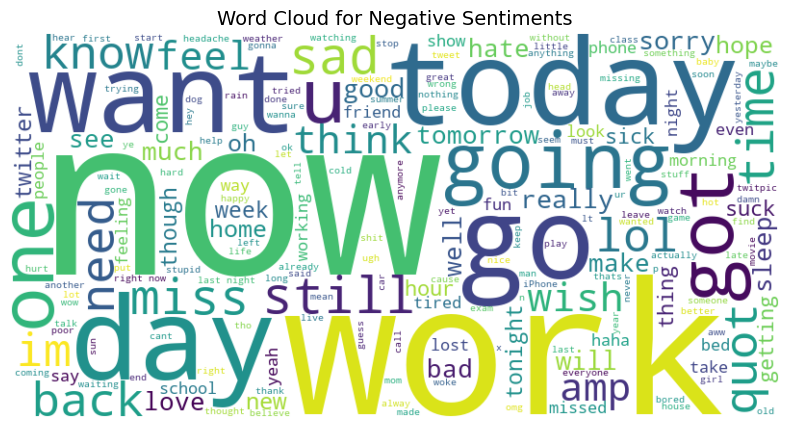

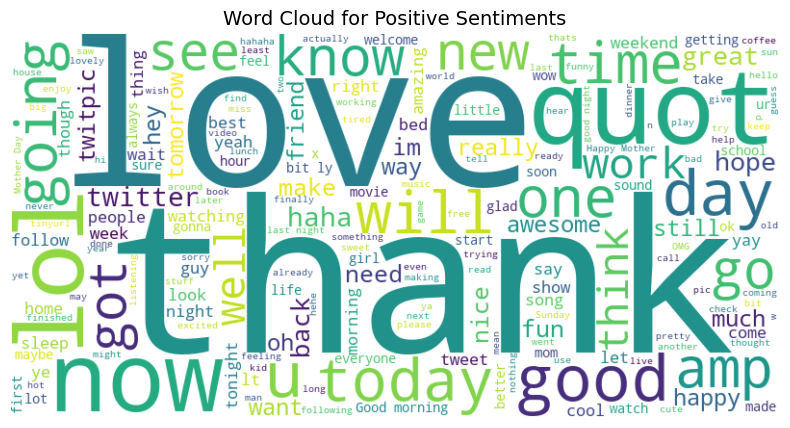

In [14]:
# Word Clouds for Each Sentiment Class
for sentiment_class in data['Target'].unique():
    text = ' '.join(data[data['Target'] == sentiment_class]['Text'])
    create_word_cloud(text, title=f'Word Cloud for {sentiment_class_map[sentiment_class]} Sentiments' )

In [15]:
def custom_tokenizer(text):
    """
    Define a tokenizer to perform these steps using SpaCy
     - Remove mentions & URLs
     - Remove HTML characters
     - Remove Stop Words 
     - Remove Punctuations, Quotations & Extra Spaces
     - Remove token with digits 
    """
    
    tokenized_sentence = []

    # Define a regex pattern to match URLs
    url_pattern = r'https?://\S+|www\.\S+'
    text_without_urls = re.sub(url_pattern, '', text)
    
    # Decode HTML entities in the text (excluding URLs)
    decoded_text = html.unescape(text_without_urls)
    
    # Define regex pattern to match digits
    digit_pattern = re.compile(r'\d')
    
    doc = nlp(decoded_text)
    
    for token in doc:
        if not (token.is_stop or token.is_space or token.is_punct or token.is_quote):
            if token.like_url or token.text.startswith('@'):
                continue
                
            # Check if token contains digits
            elif digit_pattern.search(token.text):
                continue
                
            else:
                processed_token = token.lemma_
                
            tokenized_sentence.append(processed_token)
        
    return tokenized_sentence

In [16]:
# Tokenized the text data
data['tokenized_text'] = data['Text'].apply(custom_tokenizer)
data.head()[['Text','tokenized_text', 'Target']]

,Text,tokenized_text,Target
0,@Msfab1988 u so lucky @lamborghinibow answer ...,"[u, lucky, answer, u]",0
1,@chrismusick didn't work still got em,"[work, get, em]",0
2,Not doing to good....I hurt my knee last night...,"[good, hurt, knee, night, dance]",0
3,"@dulani247 Yep, I do.",[Yep],1
4,@capemaybooks i see kitteh fwendz at the #bund...,"[kitteh, fwendz, bunday, celeration]",1


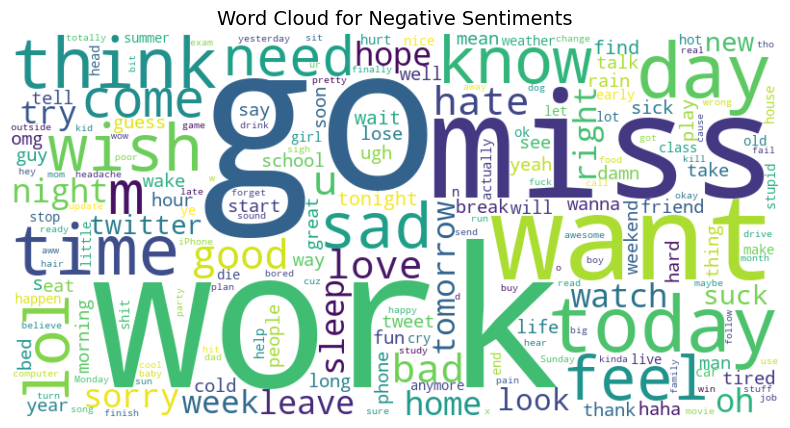

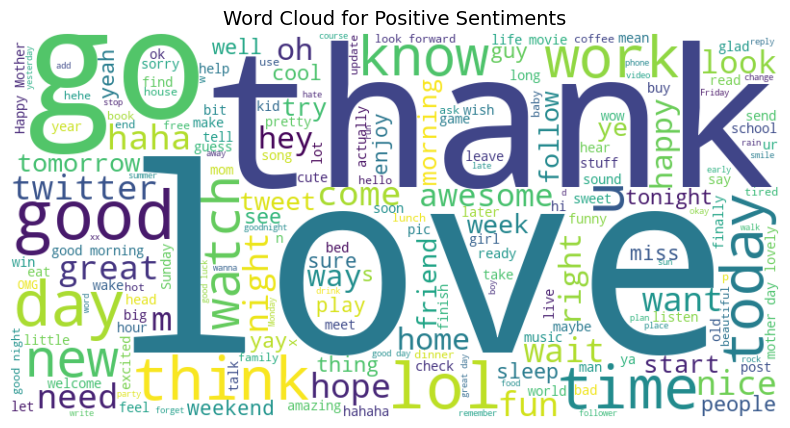

In [17]:
data['tokenized_string'] = data['tokenized_text'].apply(lambda x: ' '.join(x))

# Word Clouds of Clean Tokenized Data
for sentiment_class in data['Target'].unique():
    text = ' '.join(data[data['Target'] == sentiment_class]['tokenized_string'].explode())
    create_word_cloud(text, f'Word Cloud for Sentiment Class: {sentiment_class}')

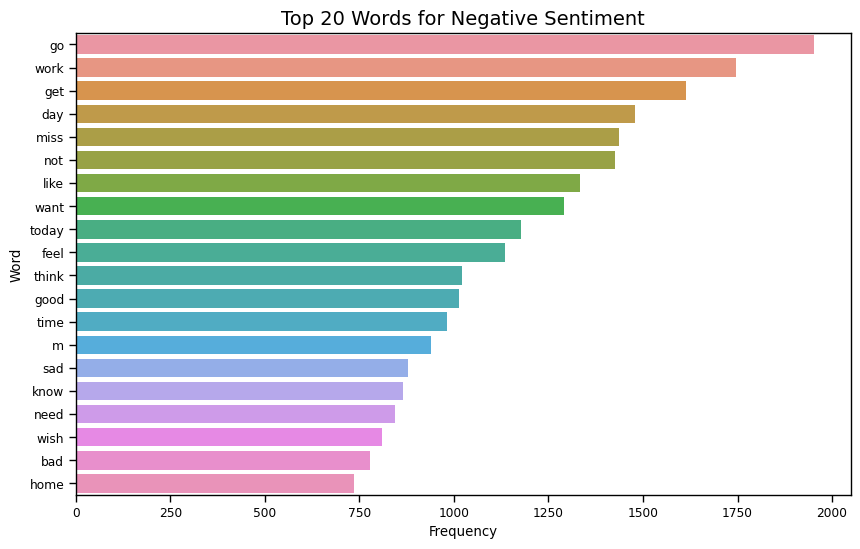

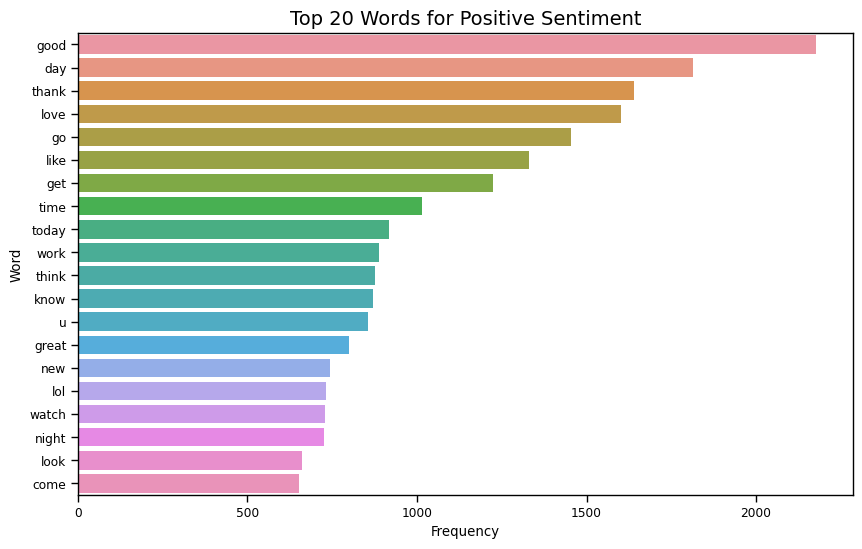

In [18]:
# Assuming you have tokenized text data in a DataFrame column named 'tokenized_text'
# and sentiment labels in a DataFrame column named 'target'

# Calculate the frequency of each word for each sentiment class
word_freq = {}
for sentiment in data['Target'].unique():
    sentiment_text = ' '.join(data[data['Target'] == sentiment]['tokenized_string'])
    word_freq[sentiment] = pd.Series(sentiment_text.split()).value_counts()

# Select the top 20 most frequent words for each sentiment class
top_words = {}
for sentiment, freq in word_freq.items():
    top_words[sentiment] = freq.head(20)

# Create and display treemap plot for each sentiment class separately
for sentiment, freq in top_words.items():
    plt.figure(figsize=(10, 6))
    sns.barplot(x=freq.values, y=freq.index)
    plt.title(f'Top 20 Words for {sentiment_class_map[sentiment]} Sentiment')
    plt.xlabel('Frequency')
    plt.ylabel('Word')
    plt.show()

C:\Users\Saydain Sheikh\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


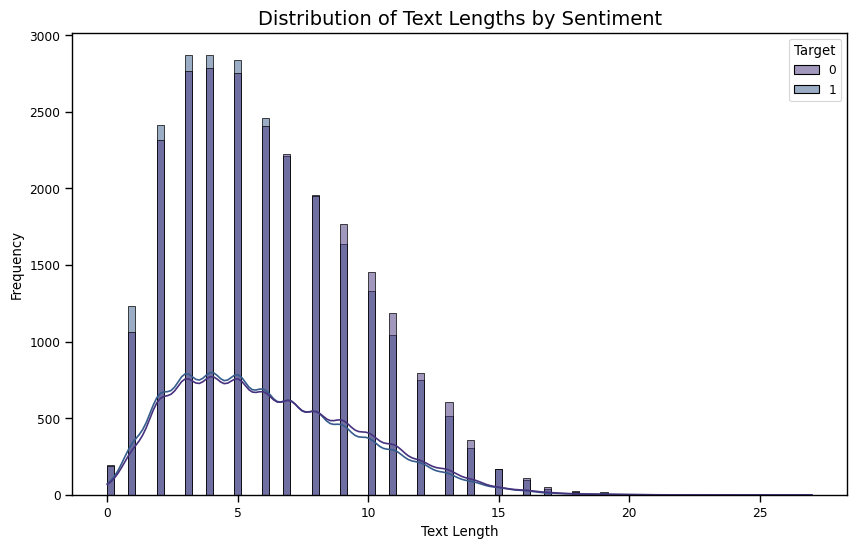

In [19]:
# Check the Distribution of Tweet Length Sentiment Wise
data['text_length'] = data['tokenized_text'].apply(len)

plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='text_length', hue='Target', kde=True)
plt.title('Distribution of Text Lengths by Sentiment')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

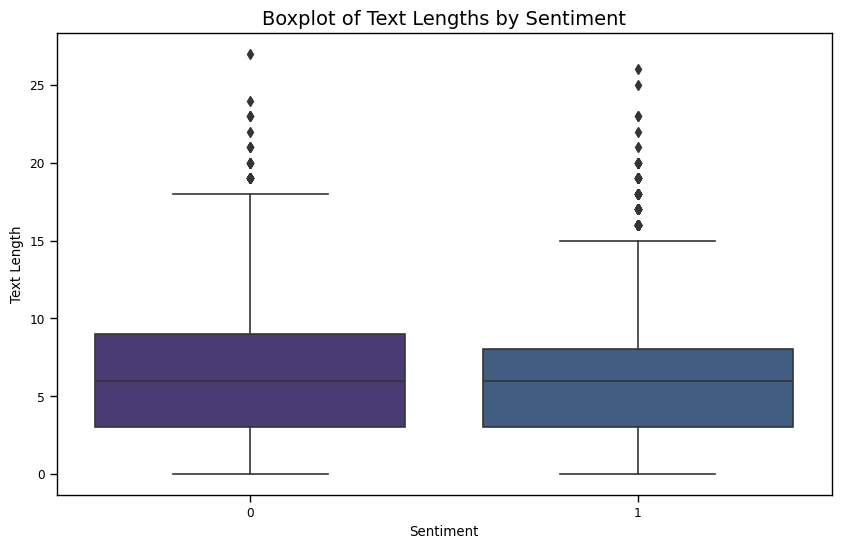

In [20]:
# Visualize Tweet Length Distribution By Sentiment Using boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=data, x='Target', y='text_length')
plt.title('Boxplot of Text Lengths by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Text Length')
plt.show()

# TF-IDF Vectorization

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    data['tokenized_text'], data['Target'], test_size=0.2,random_state=42
) 

In [22]:
def identity_tokenizer(text):
    return text
    
# Create the TF-IDF Vectors
tfidf_vectorizer = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False, token_pattern=None)  # You can adjust max_features as needed
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)


# Model Training & Evaluation

In [23]:
from sklearn.model_selection import train_test_split, GridSearchCV

In [24]:
nb_classifier = MultinomialNB()
param_grid = {
    'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]  # Example range; adjust based on your dataset
}


In [25]:
grid_search = GridSearchCV(estimator=nb_classifier, param_grid=param_grid, n_jobs=-1, cv=5, scoring='accuracy')
grid_search.fit(X_train_tfidf, y_train)


GridSearchCV(cv=5, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]},
             scoring='accuracy')

In [26]:
print("Best Parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

# Predict on the test data
predictions = best_model.predict(X_test_tfidf)

# Print classification report
print(classification_report(y_test, predictions))


Best Parameters: {'alpha': 10.0}
              precision    recall  f1-score   support

           0       0.72      0.79      0.75      4981
           1       0.77      0.69      0.73      5019

    accuracy                           0.74     10000
   macro avg       0.74      0.74      0.74     10000
weighted avg       0.74      0.74      0.74     10000



In [27]:
# Naive Bayes Model after Hyperparameter Tuning
naive_bayes_classifier = MultinomialNB(alpha = 10.0)
naive_bayes_classifier.fit(X_train_tfidf, y_train)

MultinomialNB(alpha=10.0)

In [28]:
# Evaluate the Model
y_pred = naive_bayes_classifier.predict(X_test_tfidf)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Generate classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.7386
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.79      0.75      4981
           1       0.77      0.69      0.73      5019

    accuracy                           0.74     10000
   macro avg       0.74      0.74      0.74     10000
weighted avg       0.74      0.74      0.74     10000



In [29]:
X_test.shape

(10000,)

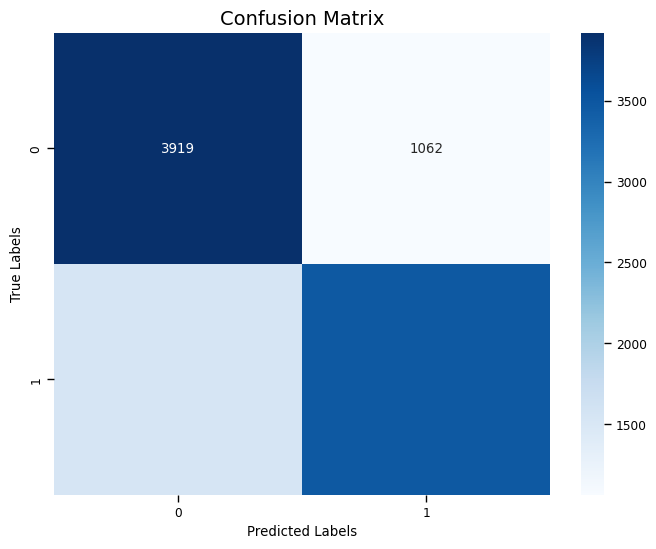

In [30]:
# Compute Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred, labels=naive_bayes_classifier.classes_)
# conf_matrix2 = confusion_matrix(y_train, y_pred)
# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=True)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [31]:
print(conf_matrix)

[[3919 1062]
 [1552 3467]]


AUC: 0.8241345405027649


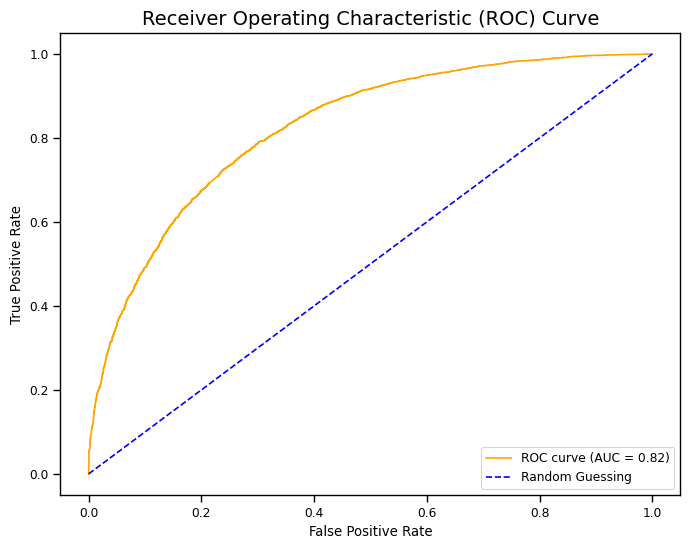

In [32]:
# Compute ROC Curve and AUC
# Compute probabilities for positive class (class 1)
y_probs = naive_bayes_classifier.predict_proba(X_test_tfidf)[:, 1]

# Compute AUC
auc_score = roc_auc_score(y_test, y_probs)
print("AUC:", auc_score)

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='orange', label='ROC curve (AUC = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='blue', linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

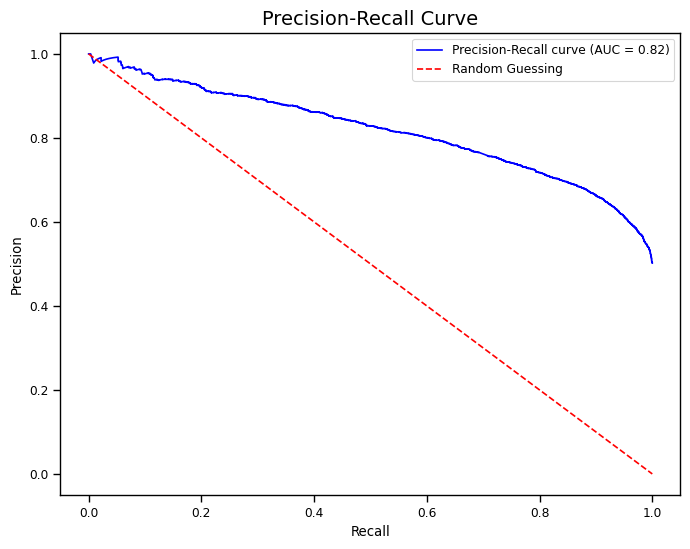

In [33]:
# Compute Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_probs)

# Compute AUC for Precision-Recall curve
pr_auc = auc(recall, precision)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='orange', label='Precision-Recall curve (AUC = %0.2f)' % pr_auc)
plt.plot([0, 1], [1, 0], color='blue', linestyle='--', label='Random Guessing')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='upper right')
plt.show()

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [35]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, GlobalMaxPooling1D, SimpleRNN
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint

In [36]:
# converting the strings into integers using Tokenizer 

# instantiating the tokenizer
max_vocab = 20000000
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(X_train)

# checking the word index and find out the vocabulary of the dataset
wordidx = tokenizer.word_index
V = len(wordidx)
print('The size of datatset vocab is: ', V)

# converting tran and test sentences into sequences
train_seq = tokenizer.texts_to_sequences(X_train)
test_seq = tokenizer.texts_to_sequences(X_test)
print('Training sequence: ', train_seq[0])
print('Testing sequence: ', test_seq[0])

The size of datatset vocab is:  27476
Training sequence:  [80, 1529, 20, 422, 7, 10686, 290, 422, 61]
Testing sequence:  [2226, 411, 70, 150, 41, 14]


In [37]:
# padding the sequences to get equal length sequence because its conventional to use same size sequences
# padding the traing sequence
pad_train = pad_sequences(train_seq)
T = pad_train.shape[1]
print('The length of training sequence is: ', T)

# padding the test sequence
pad_test = pad_sequences(test_seq, maxlen=T)
print('The length of testing sequence is: ', pad_test.shape[1])

The length of training sequence is:  27
The length of testing sequence is:  27


## Training Loop

In [38]:
def train(model, pad_train, y_train, pad_test, y_test, model_id, epochs=2):
    # Define the checkpoint directory and file format including the model ID
    checkpoint_filepath = f'model_checkpoints/model_{model_id}/model-' + '{epoch:02d}.weights.h5'
    
    # Create a ModelCheckpoint callback that saves the model's weights
    checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,  # Change to False if you want to save the entire model
        save_best_only=False,    # Change to True to save only when the monitored metric improves
        save_freq='epoch',       # 'epoch' to save after each epoch
        verbose=1                # Logs a message whenever the model is being saved
    )

    # Function to calculate F1 score, defined within the train function
    def f1_score(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)  # Ensure y_true is float32
        y_pred = tf.cast(y_pred, tf.float32)  # Ensure y_pred is float32
        
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        
        precision = true_positives / (predicted_positives + K.epsilon())
        recall = true_positives / (possible_positives + K.epsilon())
        
        f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
        return f1_val

    # Compiling the model
    model.compile(
        optimizer='adam', 
        loss='binary_crossentropy', 
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            f1_score
        ]
    )

    # Training the model with the ModelCheckpoint callback
    r = model.fit(
        pad_train, y_train, 
        validation_data=(pad_test, y_test), 
        epochs=epochs,
        callbacks=[checkpoint_callback]  # Add the checkpoint callback
    )

    return r

## Evaluation Definition

In [39]:
def evaluate(r):
    # Assume 'r' is the result from model.fit()
    fig, axs = plt.subplots(3, 2, figsize=(12, 18))  # 3 rows, 2 columns

    # Plot configuration to avoid overlapping
    plt.subplots_adjust(hspace=0.4)

    # Loss Plot
    axs[0, 0].plot(r.history['loss'], label='Training Loss')
    axs[0, 0].plot(r.history['val_loss'], label='Validation Loss')
    axs[0, 0].set_title('Loss vs. Validation Loss')
    axs[0, 0].legend()
    axs[0, 0].set_xlabel('Epoch')
    axs[0, 0].set_ylabel('Loss')

    # Accuracy Plot
    axs[0, 1].plot(r.history['accuracy'], label='Training Accuracy')
    axs[0, 1].plot(r.history['val_accuracy'], label='Validation Accuracy')
    axs[0, 1].set_title('Accuracy vs. Validation Accuracy')
    axs[0, 1].legend()
    axs[0, 1].set_xlabel('Epoch')
    axs[0, 1].set_ylabel('Accuracy')

    # Precision Plot
    axs[1, 0].plot(r.history['precision'], label='Training Precision')
    axs[1, 0].plot(r.history['val_precision'], label='Validation Precision')
    axs[1, 0].set_title('Precision vs. Validation Precision')
    axs[1, 0].legend()
    axs[1, 0].set_xlabel('Epoch')
    axs[1, 0].set_ylabel('Precision')

    # Recall Plot
    axs[1, 1].plot(r.history['recall'], label='Training Recall')
    axs[1, 1].plot(r.history['val_recall'], label='Validation Recall')
    axs[1, 1].set_title('Recall vs. Validation Recall')
    axs[1, 1].legend()
    axs[1, 1].set_xlabel('Epoch')
    axs[1, 1].set_ylabel('Recall')

    # F1 Score Plot (if f1_score is in history)
    if 'f1_score' in r.history:
        axs[2, 0].plot(r.history['f1_score'], label='Training F1 Score')
        axs[2, 0].plot(r.history['val_f1_score'], label='Validation F1 Score')
        axs[2, 0].set_title('F1 Score vs. Validation F1 Score')
        axs[2, 0].legend()
        axs[2, 0].set_xlabel('Epoch')
        axs[2, 0].set_ylabel('F1 Score')

    # Leave the last subplot empty (or remove it for visual clarity)
    axs[2, 1].axis('off')

    plt.show()

    print("Final Validation Loss:", r.history['val_loss'][-1])
    print("Final Validation Accuracy:", r.history['val_accuracy'][-1])
    print("Final Validation Precision:", r.history['val_precision'][-1])
    print("Final Validation Recall:", r.history['val_recall'][-1])

    # Check if F1 Score was tracked and print it
    if 'val_f1_score' in r.history:
        print("Final Validation F1 Score:", r.history['val_f1_score'][-1])

def predict_sentiment(model, text):
  # preprocessing the given text 
  text_seq = tokenizer.texts_to_sequences(text)
  text_pad = pad_sequences(text_seq, maxlen=T)

  # predicting the class
  predicted_sentiment = model.predict(text_pad).round()

  if predicted_sentiment == 1.0:
    return(print('It is a positive sentiment'))
  else:
    return(print('It is a negative sentiment'))

## RNN

### Training

In [40]:
D = 20 
M = 15

i = Input (shape=(T, ))   
x = Embedding(V+1, D)(i)    # V+1 because the indexing of the words in vocab (V) start from 1 not 0
x = SimpleRNN(M, return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(32, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)

rnn_model = Model(i,x)

rnn_r = train(rnn_model, pad_train, y_train, pad_test, y_test, 'rnn')

Epoch 1/2
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5996 - f1_score: 0.5784 - loss: 0.6472 - precision: 0.5976 - recall: 0.6377
Epoch 1: saving model to model_checkpoints/model_rnn/model-01.weights.h5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.5997 - f1_score: 0.5785 - loss: 0.6471 - precision: 0.5977 - recall: 0.6378 - val_accuracy: 0.7391 - val_f1_score: 0.7337 - val_loss: 0.5215 - val_precision: 0.7410 - val_recall: 0.7382
Epoch 2/2
1242/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8051 - f1_score: 0.7988 - loss: 0.4295 - precision: 0.8002 - recall: 0.8068
Epoch 2: saving model to model_checkpoints/model_rnn/model-02.weights.h5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.8050 - f1_score: 0.7987 - loss: 0.4295 - precision: 0.8001 - recall: 0.8067 - val_accuracy: 0.7405 - val_f1_score: 0.7362 - val_loss: 0.5335 - val_precision: 0.7410 - val_recall: 0.7426


#### Evaluation

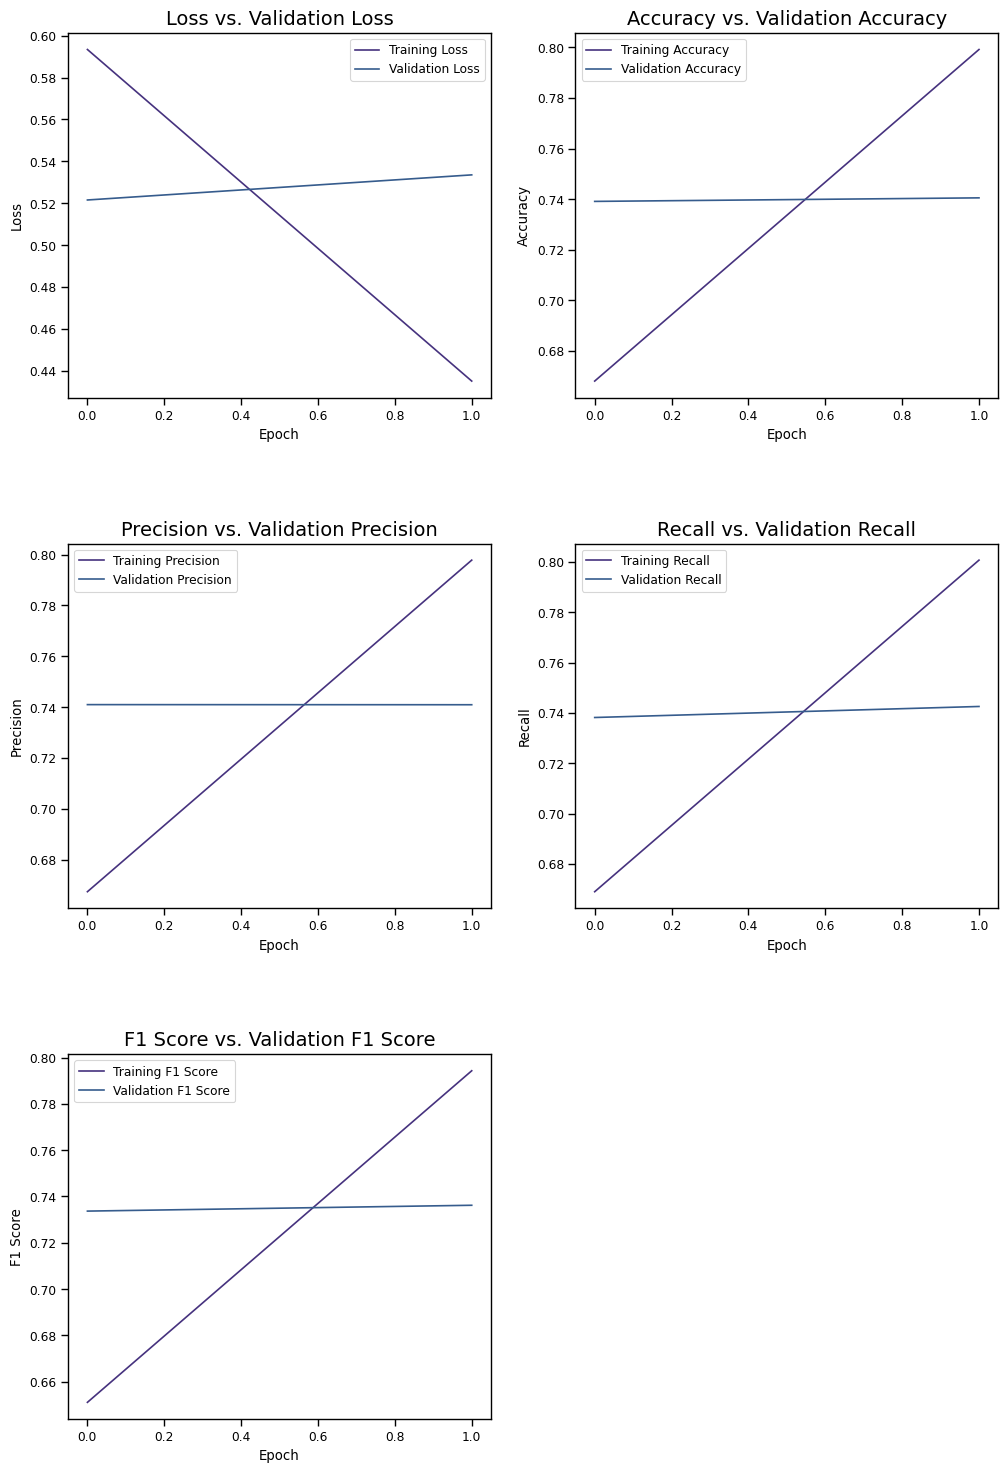

Final Validation Loss: 0.5335371494293213
Final Validation Accuracy: 0.7404999732971191
Final Validation Precision: 0.7409542798995972
Final Validation Recall: 0.7425782084465027
Final Validation F1 Score: 0.7362102270126343


In [41]:
evaluate(rnn_r)

In [42]:
X_test.head()

33553            [smh, definitely, play, game, right, lol]
9427                    [oh, hey, btw, looove, new, photo]
199                [apple, delay, iPhone, os, minute, day]
12447    [foot, hurt, design, pack, LA, bed, oi, task, ...
39489    [Metro, tragedy, crush, remind, people, Metro,...
Name: tokenized_text, dtype: object

In [43]:
X_test.shape

(10000,)

In [44]:
X_test.info()

<class 'pandas.core.series.Series'>
Index: 10000 entries, 33553 to 5857
Series name: tokenized_text
Non-Null Count  Dtype 
--------------  ----- 
10000 non-null  object
dtypes: object(1)
memory usage: 156.2+ KB


## LSTM

### Training

In [45]:
D = 20 
M = 15

i = Input (shape=(T, ))   
x = Embedding(V+1, D)(i)    # V+1 because the indexing of the words in vocab (V) start from 1 not 0
x = LSTM(M, return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(32, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)

lstm_model = Model(i,x)

lstm_r = train(lstm_model, pad_train, y_train, pad_test, y_test, 'lstm')

Epoch 1/2
1245/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6462 - f1_score: 0.4748 - loss: 0.6049 - precision: 0.6520 - recall: 0.4802
Epoch 1: saving model to model_checkpoints/model_lstm/model-01.weights.h5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.6465 - f1_score: 0.4756 - loss: 0.6046 - precision: 0.6524 - recall: 0.4811 - val_accuracy: 0.7502 - val_f1_score: 0.7589 - val_loss: 0.5062 - val_precision: 0.7246 - val_recall: 0.8101
Epoch 2/2
1247/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8043 - f1_score: 0.8011 - loss: 0.4252 - precision: 0.8024 - recall: 0.8096
Epoch 2: saving model to model_checkpoints/model_lstm/model-02.weights.h5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.8043 - f1_score: 0.8011 - loss: 0.4252 - precision: 0.8023 - recall: 0.8096 - val_accuracy: 0.7388 - val_f1_score: 0.7504 - val_loss: 0.5270 - val_precision: 0.7113 - val_recall: 0.8071


#### Evaluation

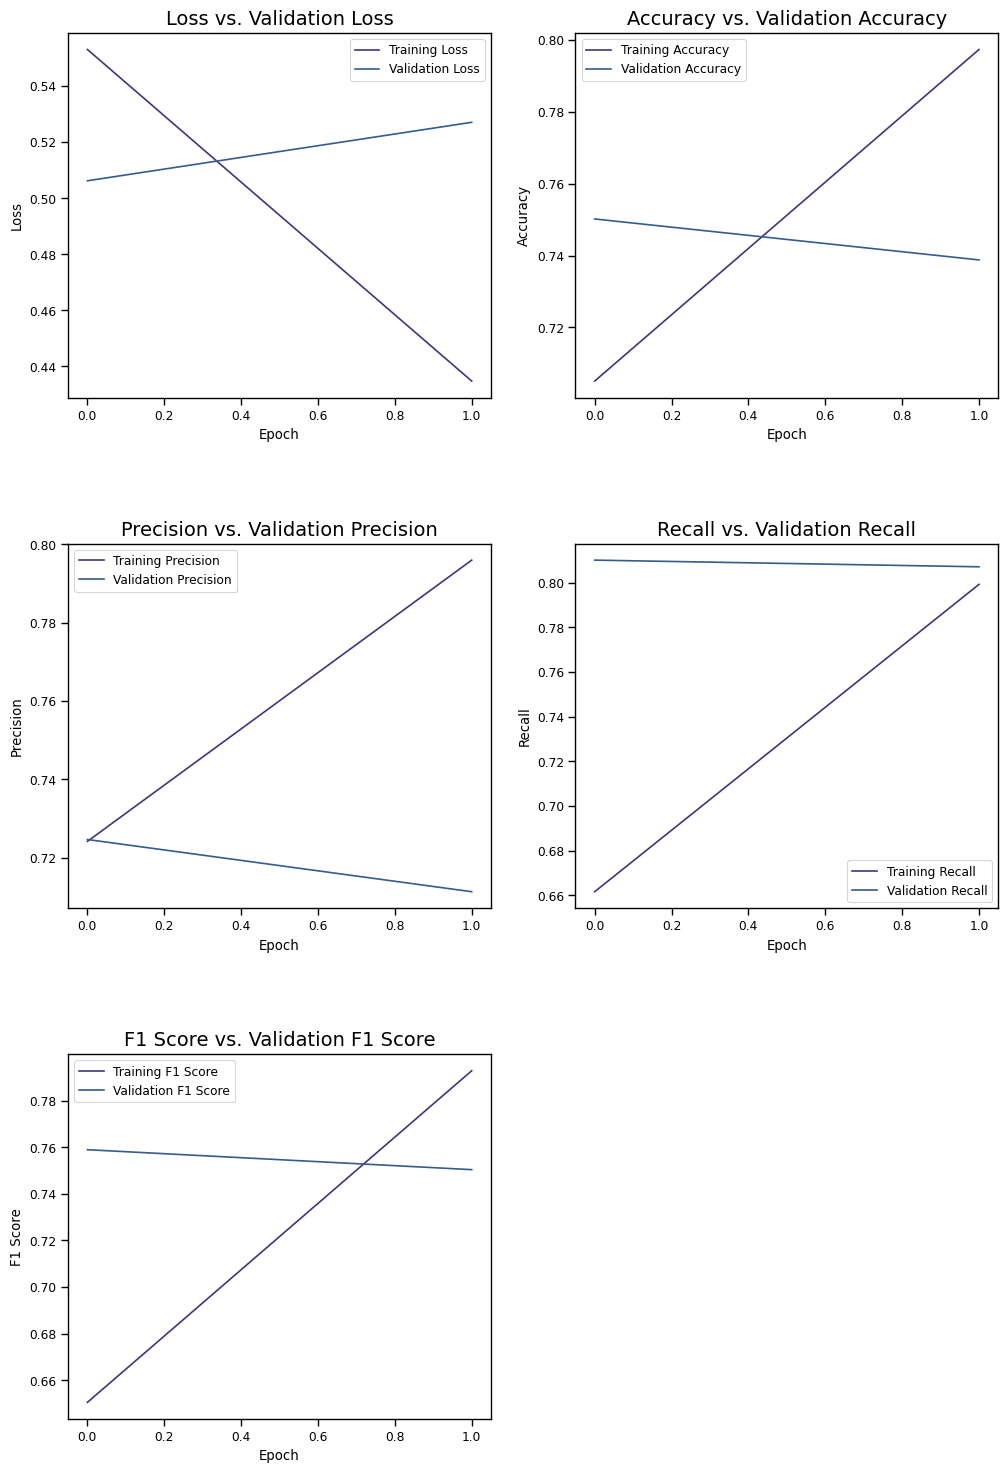

Final Validation Loss: 0.5270465612411499
Final Validation Accuracy: 0.7387999892234802
Final Validation Precision: 0.7113257050514221
Final Validation Recall: 0.8071328997612
Final Validation F1 Score: 0.7503549456596375


In [46]:
evaluate(lstm_r)